In [177]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')

In [178]:
def replace_by_symbols(txt):
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tbh", 'to be honest', txt)   # tbh: to be honest
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"i\'m", 'i am', txt)
    txt = re.sub(r"you\'re", 'you are', txt)
    txt = re.sub(r"he\'s", 'he is', txt)
    txt = re.sub(r"she\'s", 'she is', txt)
    txt = re.sub(r"it\'s", 'it is', txt)
    txt = re.sub(r"we\'re", 'we are', txt)
    txt = re.sub(r"they\'re", 'they are', txt)
    txt = re.sub(r"isn\'t", 'is not', txt)
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"haven\'t", 'have not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"couldn\'t", 'could not', txt)
    txt = re.sub(r"wouldn\'t", 'would not', txt)
    txt = re.sub(r"shouldn\'t", 'should not', txt)
    txt = re.sub(r"&amp", '', txt)
    return txt

In [179]:
patients = dict()
ordinarys = dict()
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines():
        patient = patient.strip()
        patients[patient] = peopleInfo.Patient(patient)
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = peopleInfo.Ordinary(ordinary)

In [181]:
patients = filterMethods.filter_user_by_tweet_number(patients)
ordinarys = filterMethods.filter_user_by_tweet_number(ordinarys)

Remove users:[]
Remove users:[]


In [182]:
base_texts = []
group_texts = []

for key in patients.keys():
    group_texts.append(replace_by_symbols('\n'.join(patients[key].getText())))

for key in ordinarys.keys():
    base_texts.append(replace_by_symbols('\n'.join(ordinarys[key].getText())))

corpus = base_texts + group_texts

# Functions

In [183]:
def getTopFeatures(vectorizer, classifier, k=50):
    vector2word = vectorizer.get_feature_names()
    feature_indicies = np.argsort(classifier.feature_importances_)
    top_words = []
    for i in range(k):
        vector = feature_indicies[-i-1]
        word = vector2word[vector]
        top_words.append(word)
    return top_words

In [195]:
def create_vectorizer(ngrams=1):
    vectorizer = TfidfVectorizer(stop_words="english", token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b', ngram_range = (ngrams,ngrams), min_df=1)
    return vectorizer

In [185]:
def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    words = []
    scores = []
    for item in sorted_scores:
        words.append(item[0])
        scores.append(item[1])
    return words, scores

# Tf-idf with Randomforest

In [186]:
vectorizer = TfidfVectorizer(stop_words="english", token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b', ngram_range = (2,2), min_df=1)
X = vectorizer.fit_transform(corpus)
Y = np.array([0] * len(base_texts) + [1]*len(group_texts), dtype=int)
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifier.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
top100 = getTopFeatures(vectorizer, classifier, k=100)

# Tf-idf without Randomforest

In [188]:
vectorizer_base = create_vectorizer()
tfidf_result_base = vectorizer_base.fit_transform(base_texts)
words_base, scores_base = display_scores(vectorizer_base, tfidf_result_base)

In [189]:
vectorizer_group = create_vectorizer()
tfidf_result_group = vectorizer_group.fit_transform(group_texts)
words_group, scores_group = display_scores(vectorizer_group, tfidf_result_group)

In [196]:
vectorizer_base = create_vectorizer(ngrams=2)
tfidf_result_base = vectorizer_base.fit_transform(base_texts)
words_base, scores_base = display_scores(vectorizer_base, tfidf_result_base)

In [197]:
vectorizer_group = create_vectorizer(ngrams=2)
tfidf_result_group = vectorizer_group.fit_transform(group_texts)
words_group, scores_group = display_scores(vectorizer_group, tfidf_result_group)

# Find correspond scores

In [198]:
with open('top100_correspond20170911_2', 'w') as open_file:
    for top in top100:
        if top in words_base and top in words_group:
#             print('{0}\tBase\t{1}\tGroup\t{2}'.format(top,scores_base,scores_group))
            index_base = words_base.index(top)
            index_group = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index_base],scores_group[index_group]))
        elif top in words_base:
#             print('{0}\tBase\t{1}'.format(top,scores_base))
            index = words_base.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index],0))
        elif top in words_group:
#             print('{0}\tGroup\t{1}'.format(top,scores_group))
            index = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,0,scores_group[index]))
        else:
#             print('{0}\tNot found')
            open_file.write('{0:20}\tNot found\n')

In [191]:
top100

['diagnosed depression',
 'thank love',
 'really good',
 'like new',
 'ice cream',
 'just wanted',
 'anxiety depression',
 'make feel',
 'did think',
 'just really',
 'need help',
 'sounds like',
 'happier recently',
 'just like',
 'recently diagnosed',
 'dms open',
 'love man',
 'know just',
 'wanna talk',
 'pretty sure',
 'did want',
 'just read',
 'gonna make',
 'just know',
 'fall love',
 'like just',
 'just wanna',
 'don let',
 'happy happy',
 'looked like',
 'diagnosed anxiety',
 'gets better',
 'depression honest',
 'care just',
 'like does',
 'fuck did',
 'feeling depressed',
 'know like',
 'really really',
 'love love',
 'honest videos',
 'makes feel',
 'friends just',
 'misslexamae photo',
 'make happy',
 'finally got',
 'thank thank',
 'think fucking',
 'videos help',
 'years ago',
 'need friends',
 'just makes',
 'won let',
 'feels like',
 'like fuck',
 'know feeling',
 'bed day',
 'think gonna',
 'right thank',
 'years later',
 'whore long',
 'need just',
 'time like',
 'r

In [200]:
with open('top100_correspond20170911_2', 'w') as open_file:
    for top in top100:
        if top in words_base and top in words_group:
#             print('{0}\tBase\t{1}\tGroup\t{2}'.format(top,scores_base,scores_group))
            index_base = words_base.index(top)
            index_group = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index_base],scores_group[index_group]))
        elif top in words_base:
#             print('{0}\tBase\t{1}'.format(top,scores_base))
            index = words_base.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,scores_base[index],0))
        elif top in words_group:
#             print('{0}\tGroup\t{1}'.format(top,scores_group))
            index = words_group.index(top)
            open_file.write('{0:20}\tBase\t{1}\tGroup\t{2}\n'.format(top,0,scores_group[index]))
        else:
#             print('{0}\tNot found')
            open_file.write('{0:20}\tNot found\n')

# Visualization

In [201]:
with open('top100_correspond20170911_2') as open_file:
    words,scores_b,scores_g = [],[],[]
    for line in open_file.readlines():
        eles = line.strip().split('\t')
#         print(eles)
        words.append(re.sub(' ', '', eles[0]))
        scores_b.append(eles[2])
        scores_g.append(eles[4])

In [202]:
percentages = []
for i in range(len(scores_b)):
    total = float(scores_b[i])+float(scores_g[i])
    diff = abs(float(scores_b[i])-float(scores_g[i]))
    percentages.append(round(diff/total,4))

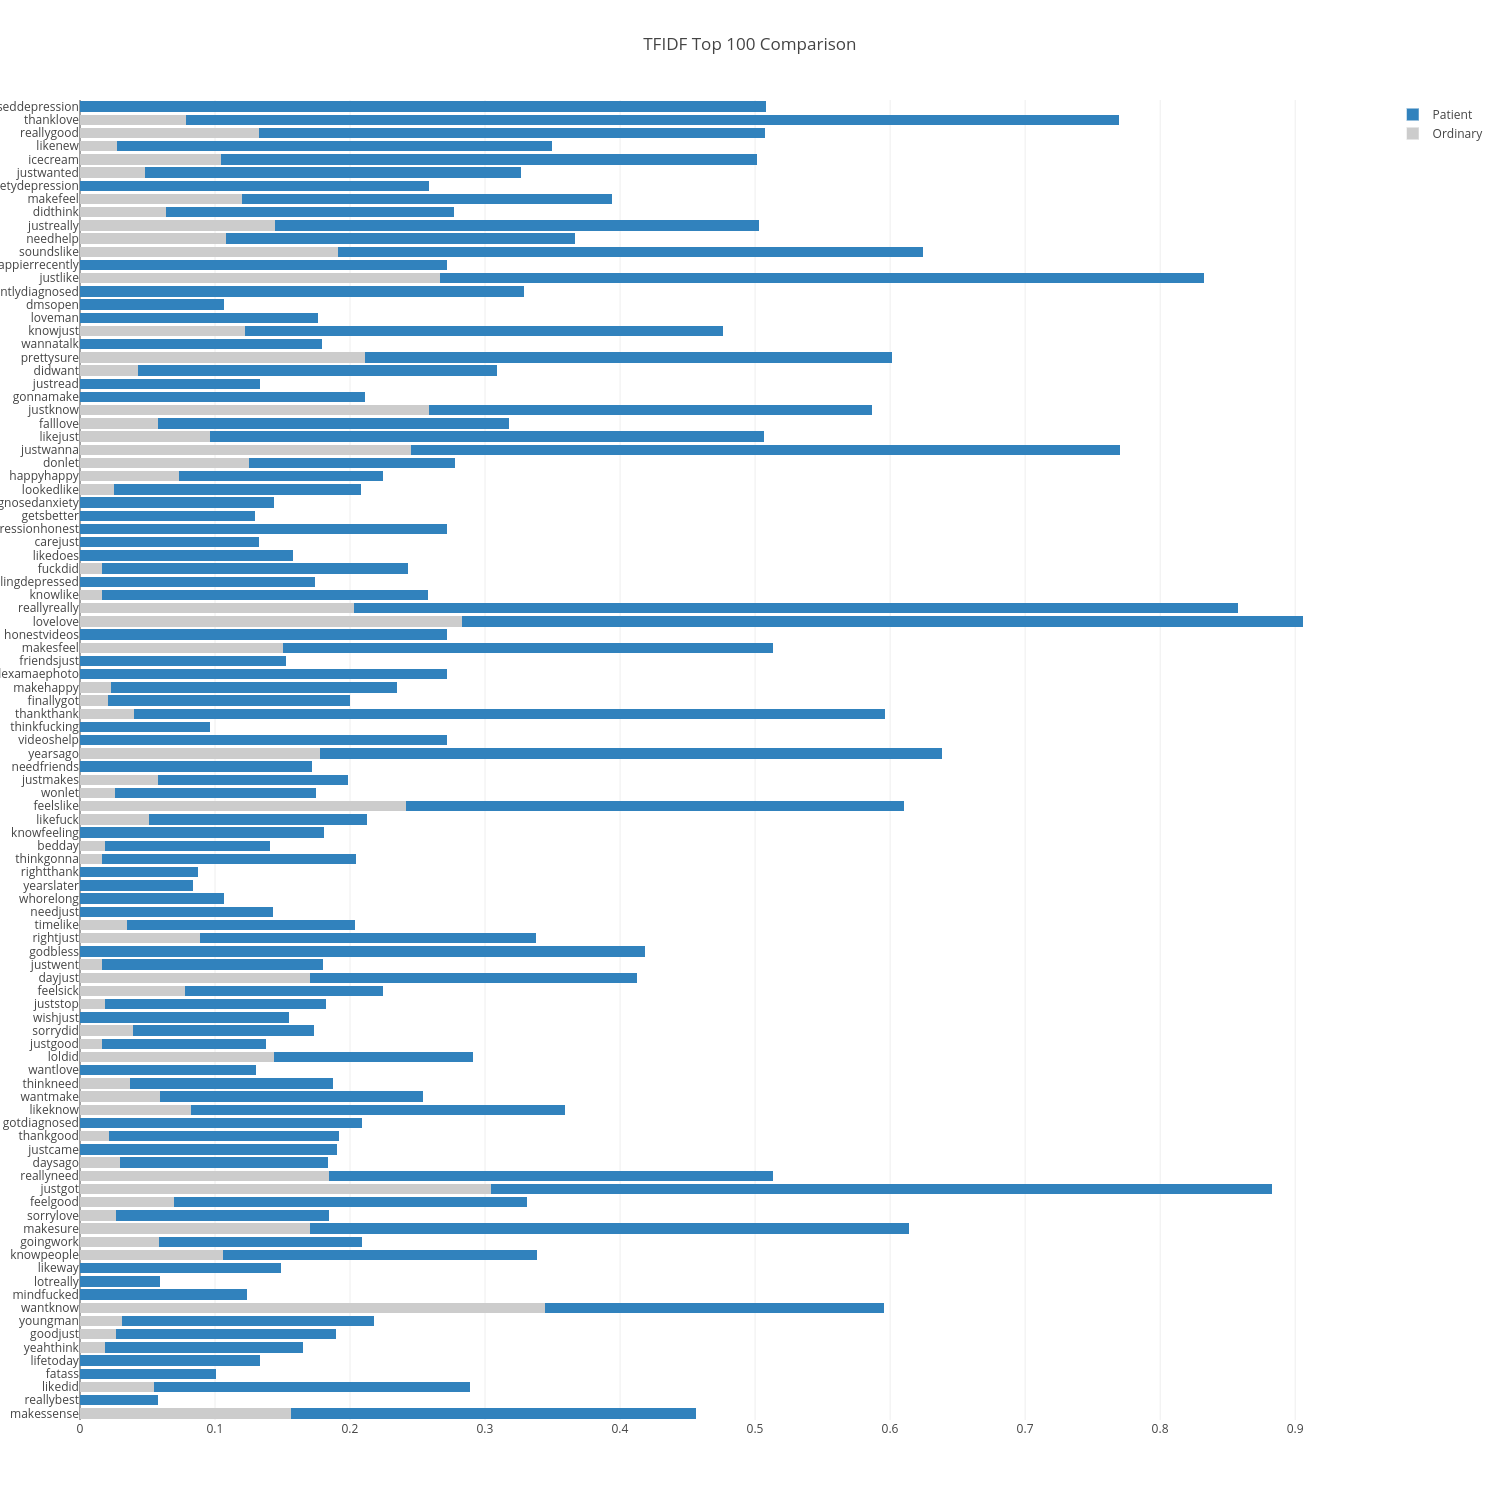

In [207]:
trace1 = go.Bar(
    x=scores_b[::-1],
    y=words[::-1],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)'),
    hoverinfo='none',
    orientation='h'
)
trace2 = go.Bar(
    x=scores_g[::-1],
    y=words[::-1],
    name='Patient',
    marker=dict(color='rgb(49,130,189)'),
    hoverinfo='none',
    orientation='h'
)
data = [trace1, trace2]
layout = go.Layout(
    title='TFIDF Top 100 Comparison',
    barmode='stack',
    autosize=False,
    width=1500,
    height=1500,
    yaxis=dict(
        dtick=1
    )
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='tfidf')
py.image.save_as(fig, filename='img/tfidf20170911_2.png')
display(Image(filename='img/tfidf20170911_2.png'))

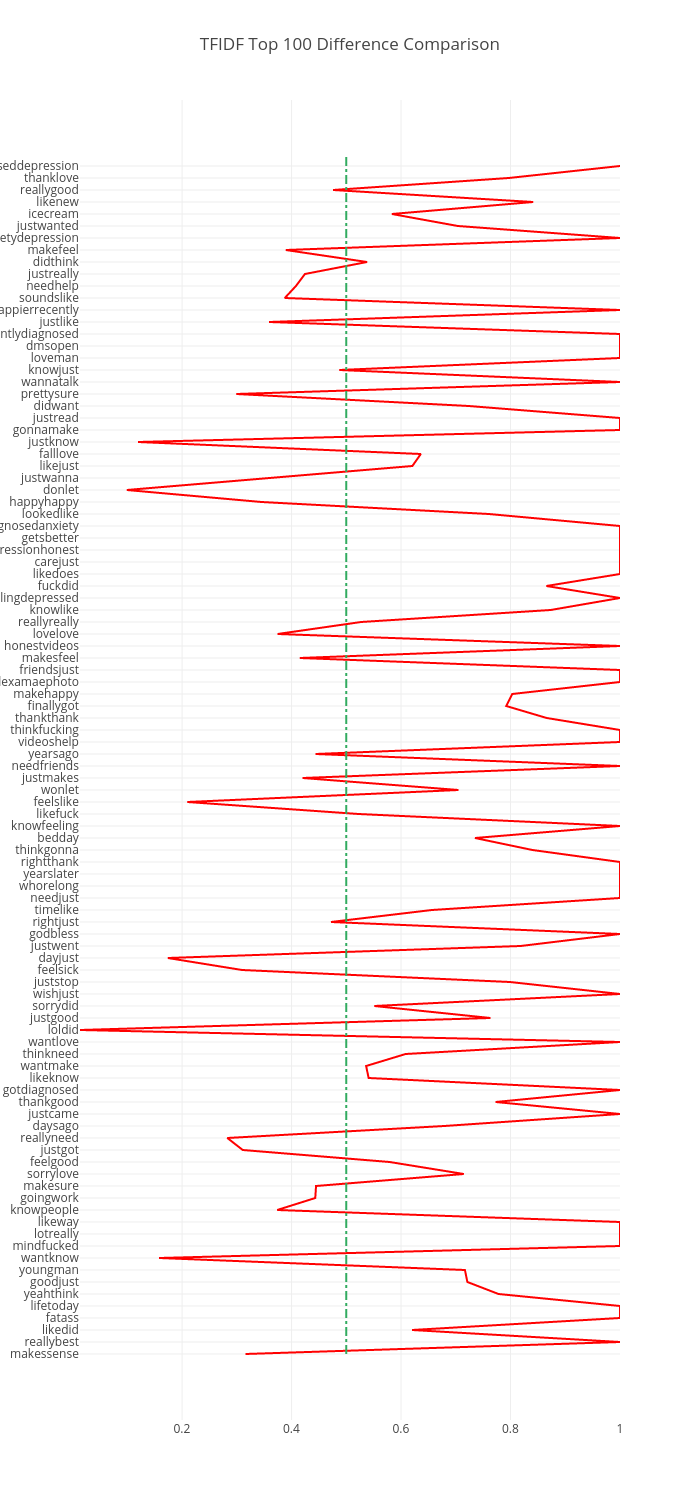

In [210]:
trace3 = go.Scatter(
    x=percentages[::-1],
    y=words[::-1],
    name='Difference',
    marker=dict(color='rgb(255, 0, 0)'),
    hoverinfo=percentages[::-1]
)
data = [trace3]
layout = go.Layout(
    title='TFIDF Top 100 Difference Comparison',
    barmode='stack',
    autosize=False,
    width=700,
    height=1500,
    yaxis=dict(
        dtick=1
    ),
    shapes=[dict({
            'type': 'line',
            'x0': 0.5,
            'y0': 0,
            'x1': 0.5,
            'y1': 100,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2,
                'dash': 'dashdot'
            }})]
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='line')
py.image.save_as(fig, filename='img/tfidf_diff20170911_2.png')
display(Image(filename='img/tfidf_diff20170911_2.png'))